In [1]:
import torch
import matplotlib.pyplot as plt
import os
import tqdm
import time
import skimage
import trimesh
import os.path as osp
import numpy as np
import pyvista as pv
pv.set_jupyter_backend('pythreejs')
import sys
sys.path.append('..')
from t4dt.t4dt import get_qtt_frame, qtt2tensor3d, oqtt2tensor3d
from t4dt.metrics import compute_metrics, hausdorff, MSDM2
from t4dt.utils import sdf2mesh
from labellines import labelLine, labelLines
from adjustText import adjust_text
plt.style.use('ggplot')
plt.rcParams.update({
  'text.usetex': True,
  'text.latex.preamble': r'\usepackage{amsmath}',
  'font.family': 'Helvetica'
})

In [52]:
ckpt1 = torch.load('../logs/sweeps/tt_tucker_00032_longshort_flying_eagle_ranks.pt')
ckpt2 = torch.load('../logs/sweeps/tt_00032_longshort_flying_eagle_ranks.pt')

In [3]:
min_tsdf, max_tsdf = -0.05, 0.05
data_dir = '/scratch2/data/cape_release/'
model = '00032'
scene = 'longshort_flying_eagle'
frames = []
for frame in sorted(os.listdir(osp.join(data_dir, 'meshes', model, scene, 'posed'))):
    if frame.startswith('sdf'):
        frames.append(frame)

In [4]:
files = [(osp.join(data_dir, 'meshes', model, scene, 'posed', frame),
              osp.join(data_dir, 'meshes', model, scene, 'posed', frame[4:-2] + 'obj'))
             for frame in frames]

In [5]:
metrics1 = {'l2': [], 'chamfer_distance': [], 'IoU': [], 'hausdorff': [], 'MSDM2': []}
metrics2 = {'l2': [], 'chamfer_distance': [], 'IoU': [], 'hausdorff': [], 'MSDM2': []}

for tucker_rank in ckpt1[(min_tsdf, max_tsdf)].keys():
    for key in metrics1.keys():
        metrics1[key].append([])
        metrics2[key].append([])
    for tt_rank in ckpt1[(min_tsdf, max_tsdf)][tucker_rank].keys():
        for key in metrics1.keys():
            metrics1[key][-1].append(
                (ckpt1[(min_tsdf, max_tsdf)][tucker_rank][tt_rank]['metrics'][0][key] +
                ckpt1[(min_tsdf, max_tsdf)][tucker_rank][tt_rank]['metrics'][142][key] +
                ckpt1[(min_tsdf, max_tsdf)][tucker_rank][tt_rank]['metrics'][283][key]) / 3
            )
            metrics2[key][-1].append(
                (ckpt2[(min_tsdf, max_tsdf)][tucker_rank][tt_rank]['metrics'][0][key] +
                ckpt2[(min_tsdf, max_tsdf)][tucker_rank][tt_rank]['metrics'][142][key] +
                ckpt2[(min_tsdf, max_tsdf)][tucker_rank][tt_rank]['metrics'][283][key]) / 3
            )

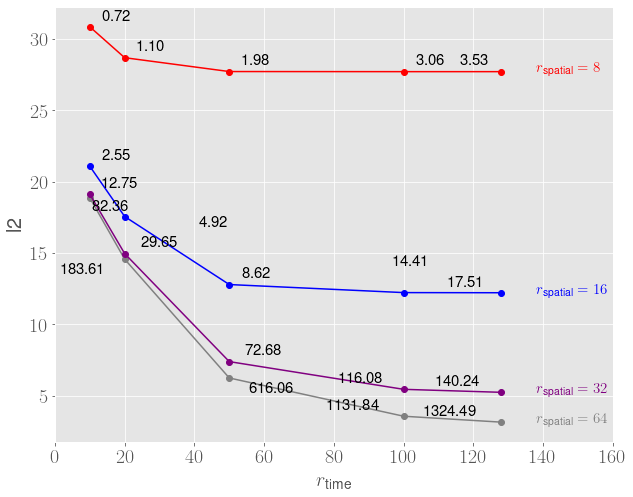

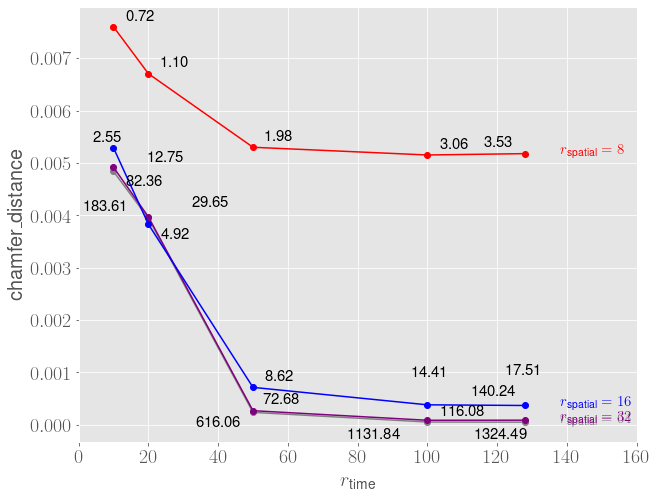

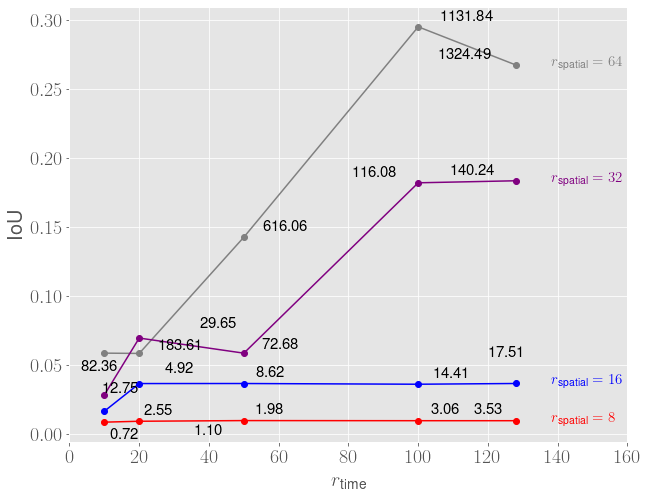

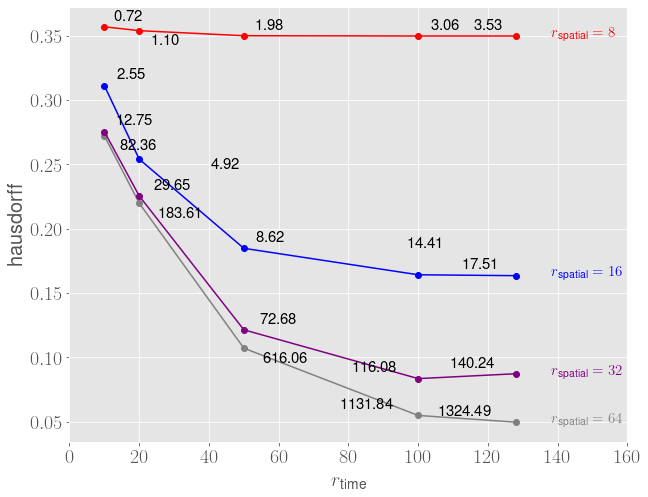

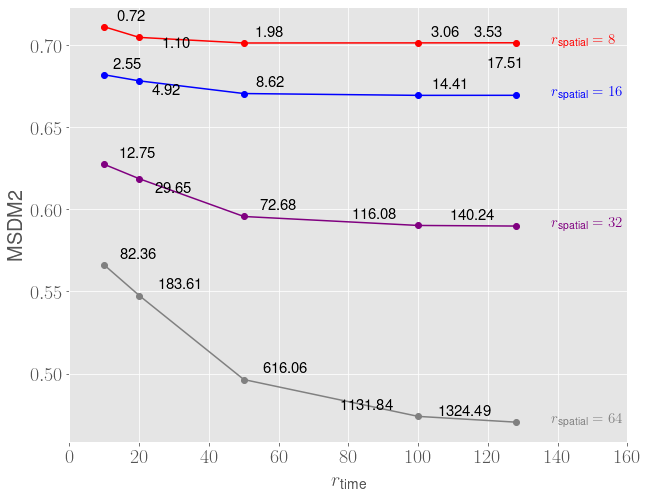

In [66]:
for key in metrics1.keys():
    fig = plt.figure(figsize=(10, 8))
    texts = []
    
    colors = ['grey', 'purple', 'blue', 'red']

    for i, inner_rank in enumerate(ckpt2[(min_tsdf, max_tsdf)].keys()):
        outer_ranks = list(ckpt1[(min_tsdf, max_tsdf)][inner_rank].keys())
        plt.plot(
            outer_ranks,
            metrics1[key][i], marker='o', color=colors[i])
#         plt.plot(
#             outer_ranks,
#             metrics2[key][i], marker='o', label=r'TT, $r_{\text{spatial}}$ ' + f'$={inner_rank}$')
        plt.text(
             outer_ranks[0] + 10,
             metrics1[key][i][0].item() if isinstance(metrics1[key][i][0], torch.Tensor) else metrics1[key][i][0],
             r'$r_{\text{spatial}}$ ' + f'$={inner_rank}$',
             fontsize=15,
             color=colors[i])
        for j, k in enumerate(outer_ranks):
            t = ckpt1[(min_tsdf, max_tsdf)][inner_rank][k]['tensor']
            texts.append(
                plt.text(
                    k,
                    metrics1[key][i][j].item() if isinstance(metrics1[key][i][j], torch.Tensor) else metrics1[key][i][j],
                    f'{(1e6 * t.numcoef() / t.numel()).item():.2f}',
                    fontsize=15))
#         plt.plot(ckpt2[(min_tsdf, max_tsdf)][inner_rank].keys(), metrics2[key][i], label=f'TT Inner rank: {inner_rank}')
#     plt.legend(loc='best', fontsize=20)
#     labelLines(fig.axes[0].get_lines(), yoffsets=-1, align=False, fontsize=20, zorder=50)
    plt.xlabel(r'$r_{\text{time}}$', fontsize=20)
    plt.ylabel(key, fontsize=20)
    plt.tick_params(axis='both', which='major', labelsize=20)
    plt.tick_params(axis='both', which='minor', labelsize=15)
    adjust_text(texts,
                expand_text=(2.05, 1.5),
                expand_points=(2.05, 1.5),
                expand_objects=(2.05, 1.5),
                expand_align=(2.05, 1.5), only_move={'points':'xy', 'texts':'xy'})
    plt.xlim(0, 160)
    plt.savefig(f'../imgs/tt_tucker_{key}.pdf')
    plt.show()

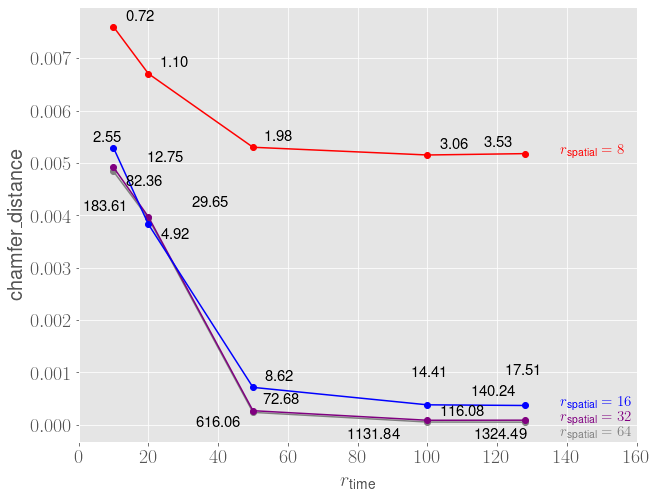

In [89]:
key = 'chamfer_distance'
fig = plt.figure(figsize=(10, 8))
texts = []

colors = ['grey', 'purple', 'blue', 'red']
offsets = [-2.5 * 1e-4, 0, 0, 0]

for i, inner_rank in enumerate(ckpt2[(min_tsdf, max_tsdf)].keys()):
    outer_ranks = list(ckpt1[(min_tsdf, max_tsdf)][inner_rank].keys())
    plt.plot(
        outer_ranks,
        metrics1[key][i], marker='o', color=colors[i])
#         plt.plot(
#             outer_ranks,
#             metrics2[key][i], marker='o', label=r'TT, $r_{\text{spatial}}$ ' + f'$={inner_rank}$')
    plt.text(
         outer_ranks[0] + 10,
         metrics1[key][i][0].item() + offsets[i],
         r'$r_{\text{spatial}}$ ' + f'$={inner_rank}$',
         fontsize=15,
         color=colors[i])
    for j, k in enumerate(outer_ranks):
        t = ckpt1[(min_tsdf, max_tsdf)][inner_rank][k]['tensor']
        texts.append(
            plt.text(
                k,
                metrics1[key][i][j].item() if isinstance(metrics1[key][i][j], torch.Tensor) else metrics1[key][i][j],
                f'{(1e6 * t.numcoef() / t.numel()).item():.2f}',
                fontsize=15))
#         plt.plot(ckpt2[(min_tsdf, max_tsdf)][inner_rank].keys(), metrics2[key][i], label=f'TT Inner rank: {inner_rank}')
#     plt.legend(loc='best', fontsize=20)
#     labelLines(fig.axes[0].get_lines(), yoffsets=-1, align=False, fontsize=20, zorder=50)
plt.xlabel(r'$r_{\text{time}}$', fontsize=20)
plt.ylabel(key, fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.tick_params(axis='both', which='minor', labelsize=15)
adjust_text(texts,
            expand_text=(2.05, 1.5),
            expand_points=(2.05, 1.5),
            expand_objects=(2.05, 1.5),
            expand_align=(2.05, 1.5), only_move={'points':'xy', 'texts':'xy'})
plt.xlim(0, 160)
plt.savefig(f'../imgs/tt_tucker_{key}.pdf')
plt.show()

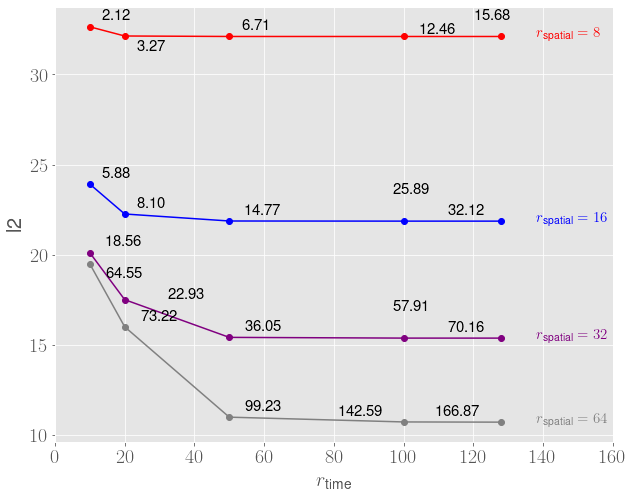

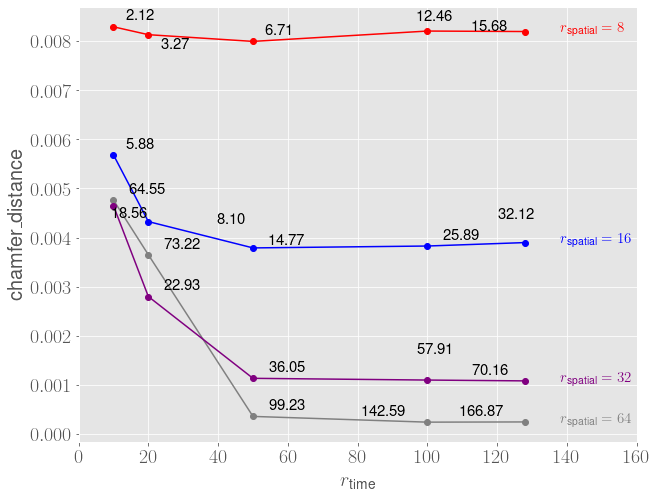

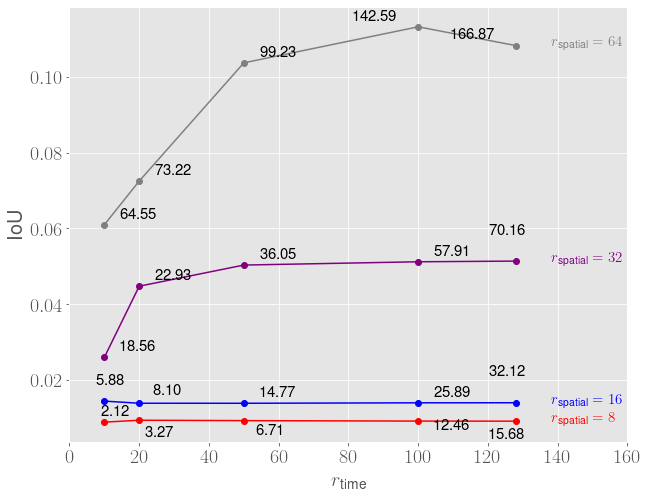

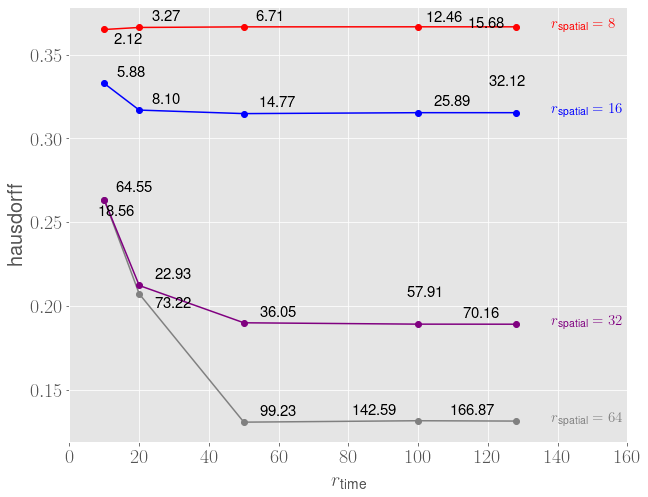

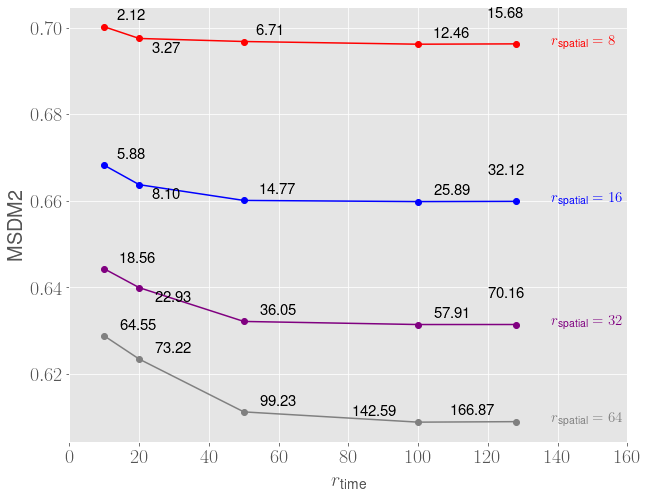

In [101]:
for key in metrics1.keys():
    fig = plt.figure(figsize=(10, 8))
    texts = []
    
    colors = ['grey', 'purple', 'blue', 'red']

    for i, inner_rank in enumerate(ckpt2[(min_tsdf, max_tsdf)].keys()):
        outer_ranks = list(ckpt1[(min_tsdf, max_tsdf)][inner_rank].keys())
        plt.plot(
            outer_ranks,
            metrics2[key][i], marker='o', color=colors[i])
        plt.text(
             outer_ranks[0] + 10,
             metrics2[key][i][0].item() if isinstance(metrics2[key][i][0], torch.Tensor) else metrics2[key][i][0],
             r'$r_{\text{spatial}}$ ' + f'$={inner_rank}$',
             fontsize=15,
             color=colors[i])
        for j, k in enumerate(outer_ranks):
            t = ckpt2[(min_tsdf, max_tsdf)][inner_rank][k]['tensor']
            texts.append(
                plt.text(
                    k,
                    metrics2[key][i][j].item() if isinstance(metrics2[key][i][j], torch.Tensor) else metrics2[key][i][j],
                    f'{(1e6 * t.numcoef() / t.numel()).item():.2f}',
                    fontsize=15))

    plt.xlabel(r'$r_{\text{time}}$', fontsize=20)
    plt.ylabel(key, fontsize=20)
    plt.tick_params(axis='both', which='major', labelsize=20)
    plt.tick_params(axis='both', which='minor', labelsize=15)
    adjust_text(texts,
                expand_text=(2.05, 1.5),
                expand_points=(2.05, 1.5),
                expand_objects=(2.05, 1.5),
                expand_align=(2.05, 1.5), only_move={'points':'xy', 'texts':'xy'})
    plt.xlim(0, 160)
    plt.savefig(f'../imgs/tt_{key}.pdf')
    plt.show()

# Renderings

In [13]:
coords = torch.tensor(
    torch.load('/scratch2/data/cape_release/meshes/00032/longshort_flying_eagle/coords.pt')['coords'])

# TT-Tucker

In [81]:
pl = pv.Plotter()
pl.camera_position = [0, 5, 10]
pl.camera.elevation = 0
pl.camera.roll = 0
pl.camera.azimuth = 0
pl.camera.zoom(1.5)

for j, i in enumerate([0, 142, 283]):
    framei = ckpt[(-0.05, 0.05)][8][10]['tensor'][..., i].torch()
    tmeshi = sdf2mesh(framei, coords)
    tmeshi.vertices += j * np.array([-1, 0, 1])
    mesh = pv.wrap(tmeshi)

    pl.add_mesh(mesh)
pl.show(screenshot=f'../imgs/lowres.png', jupyter_backend='none')

In [82]:
pl = pv.Plotter()
pl.camera_position = [0, 5, 10]
pl.camera.elevation = 0
pl.camera.roll = 0
pl.camera.azimuth = 0
pl.camera.zoom(1.5)

for j, i in enumerate([0, 142, 283]):
    framei = ckpt[(-0.05, 0.05)][64][128]['tensor'][..., i].torch()
    tmeshi = sdf2mesh(framei, coords)
    tmeshi.vertices += j * np.array([-1, 0, 1])
    mesh = pv.wrap(tmeshi)

    pl.add_mesh(mesh)
pl.show(screenshot=f'../imgs/highres.png', jupyter_backend='none')

In [87]:
pl = pv.Plotter()
pl.camera_position = [0, 5, 10]
pl.camera.elevation = 0
pl.camera.roll = 0
pl.camera.azimuth = 0
pl.camera.zoom(1.5)

for j, i in enumerate([0, 142, 283]):
    framei = torch.load(files[i][0])['sdf']
    tmeshi = sdf2mesh(framei, coords)
    tmeshi.vertices += j * np.array([-1, 0, 1])
    mesh = pv.wrap(tmeshi)

    pl.add_mesh(mesh)
pl.show(screenshot=f'../imgs/original.png', jupyter_backend='none')

In [95]:
pl = pv.Plotter()
pl.camera_position = [0, 5, 10]
pl.camera.elevation = 0
pl.camera.roll = 0
pl.camera.azimuth = 0
pl.camera.zoom(1.5)

for j, i in enumerate([0, 142, 283]):
    framei = ckpt[(-0.05, 0.05)][32][100]['tensor'][..., i].torch()
    tmeshi = sdf2mesh(framei, coords)
    tmeshi.vertices += j * np.array([-1, 0, 1])
    mesh = pv.wrap(tmeshi)

    pl.add_mesh(mesh)
pl.show(screenshot=f'../imgs/medres.png', jupyter_backend='none')

# QTT

In [2]:
ckpt = torch.load('../logs/sweeps/qtt_00032_longshort_flying_eagle_high_ranks_high_thr.pt')

In [3]:
scene = ckpt[(-0.05, 0.05)][400]['compressed_scene']

In [38]:
scene.round_tt(eps=0.5e-2)

In [41]:
rmax = 400
ranks_tt = scene.ranks_tt
ranks_tt[4::4] = torch.where(ranks_tt[4::4] < rmax, ranks_tt[4::4], rmax)
ranks_tt[3::4] = torch.where(ranks_tt[3::4] < rmax, ranks_tt[3::4], rmax)

lrs = tn.round_tt(scene.clone(), rmax=ranks_tt[1:-1])

In [45]:
scene.round_tt(rmax=2000)

In [49]:
pl = pv.Plotter()
pl.camera_position = [0, 5, 10]
pl.camera.elevation = 0
pl.camera.roll = 0
pl.camera.azimuth = 0
pl.camera.zoom(1.5)

for j, i in enumerate([0, 142, 283]):
    qtt_framei = get_qtt_frame(lrs, i)
    framei = qtt2tensor3d(qtt_framei.torch())
    tmeshi = sdf2mesh(framei, coords)
    tmeshi.vertices += j * np.array([-1, 0, 1])
    mesh = pv.wrap(tmeshi)
    pl.add_mesh(mesh)
pl.show(screenshot=f'../imgs/qtt_lowres.png', jupyter_backend='none')

# TT

In [53]:
pl = pv.Plotter()
pl.camera_position = [0, 5, 10]
pl.camera.elevation = 0
pl.camera.roll = 0
pl.camera.azimuth = 0
pl.camera.zoom(1.5)

for j, i in enumerate([0, 142, 283]):
    framei = ckpt2[(-0.05, 0.05)][8][10]['tensor'][..., i].torch()
    tmeshi = sdf2mesh(framei, coords)
    tmeshi.vertices += j * np.array([-1, 0, 1])
    mesh = pv.wrap(tmeshi)

    pl.add_mesh(mesh)
pl.show(screenshot=f'../imgs/tt_lowres.png', jupyter_backend='none')

In [54]:
pl = pv.Plotter()
pl.camera_position = [0, 5, 10]
pl.camera.elevation = 0
pl.camera.roll = 0
pl.camera.azimuth = 0
pl.camera.zoom(1.5)

for j, i in enumerate([0, 142, 283]):
    framei = ckpt2[(-0.05, 0.05)][64][128]['tensor'][..., i].torch()
    tmeshi = sdf2mesh(framei, coords)
    tmeshi.vertices += j * np.array([-1, 0, 1])
    mesh = pv.wrap(tmeshi)

    pl.add_mesh(mesh)
pl.show(screenshot=f'../imgs/tt_highres.png', jupyter_backend='none')

In [58]:
pl = pv.Plotter()
pl.camera_position = [0, 5, 10]
pl.camera.elevation = 0
pl.camera.roll = 0
pl.camera.azimuth = 0
pl.camera.zoom(1.5)

for j, i in enumerate([0, 142, 283]):
    framei = ckpt2[(-0.05, 0.05)][32][100]['tensor'][..., i].torch()
    tmeshi = sdf2mesh(framei, coords)
    tmeshi.vertices += j * np.array([-1, 0, 1])
    mesh = pv.wrap(tmeshi)

    pl.add_mesh(mesh)
pl.show(screenshot=f'../imgs/tt_medres.png', jupyter_backend='none')

In [61]:
ckpt2[(-0.05, 0.05)][8][10]['tensor'].numcoef() / ckpt2[(-0.05, 0.05)][8][10]['tensor'].numel() * 1000

tensor(0.0021, dtype=torch.float64)

In [62]:
512**3 * 284 * 64 / 8 / 2**20 * 0.0021 / 1000

0.6107136

In [63]:
0.0021 * 1e3

2.1

In [16]:
framei.max()

tensor(0.0517)

In [44]:
ranks_tt

tensor([   1,    2,    4,    8,   16,   32,   56,   92,  163,  274,  487,  400,
         400, 2209, 2778,  400,  400, 1604, 1047,  400,  371,  235,  152,   96,
          62,   43,   31,   20,   15,   12,   11,   11,    7,    5,    4,    2,
           1])

# OQTT

In [2]:
ckpt = torch.load('../logs/sweeps/oqtt_00032_longshort_flying_eagle_ranks.pt')

In [3]:
t = ckpt[(-0.05, 0.05)][400][400]['tensor']

In [4]:
ckpt[(-0.05, 0.05)][400][400]

{'tensor': 18D TT tensor:
 
   8   2   8   2   8   2   8   2   8   2   8   2   8   2   8   2   8   2
   |   |   |   |   |   |   |   |   |   |   |   |   |   |   |   |   |   |
  (0) (1) (2) (3) (4) (5) (6) (7) (8) (9) (10)(11)(12)(13)(14)(15)(16)(17)
  / \ / \ / \ / \ / \ / \ / \ / \ / \ / \ / \ / \ / \ / \ / \ / \ / \ / \
 1   8   16  101 198 284 284 284 284 284 284 284 284 151 109 22  15  2   1,
 'metrics': {0: {'l2': tensor(7.6395, dtype=torch.float64),
   'chamfer_distance': tensor(7.7609e-05, dtype=torch.float64),
   'IoU': tensor(0.0289),
   'hausdorff': 0.07318595108818728,
   'MSDM2': 0.4862104164125295},
  142: {'l2': tensor(11.2385, dtype=torch.float64),
   'chamfer_distance': tensor(0.0002, dtype=torch.float64),
   'IoU': tensor(0.0553),
   'hausdorff': 0.12506650448004367,
   'MSDM2': 0.5333570723268991},
  283: {'l2': tensor(11.0878, dtype=torch.float64),
   'chamfer_distance': tensor(0.0001, dtype=torch.float64),
   'IoU': tensor(0.1179),
   'hausdorff': 0.09496596631250036

In [5]:
t.numcoef() / t.numel()

tensor(5.0643e-05, dtype=torch.float64)

In [57]:
pl = pv.Plotter()
pl.camera_position = [0, 5, 10]
pl.camera.elevation = 0
pl.camera.roll = 0
pl.camera.azimuth = 0
pl.camera.zoom(1.5)

for j, i in enumerate([0, 142, 283]):
    oqtt_framei = get_qtt_frame(g, i, N=1)
    framei = oqtt2tensor3d(oqtt_framei.torch())
    tmeshi = sdf2mesh(framei, coords)
    tmeshi.vertices += j * np.array([-1, 0, 1])
    mesh = pv.wrap(tmeshi)

    pl.add_mesh(mesh)
pl.show(screenshot=f'../imgs/oqtt_lowres.png', jupyter_backend='none')

In [25]:
oqtt_framei

9D TT tensor:

  8   8   8   8   8   8   8   8   8
  |   |   |   |   |   |   |   |   |
 (0) (1) (2) (3) (4) (5) (6) (7) (8)
 / \ / \ / \ / \ / \ / \ / \ / \ / \
1   8   101 284 284 284 284 151 22  1

In [16]:
framei.shape

KeyboardInterrupt: 

In [6]:
oqttn = torch.load('../scripts/perda.pt')

In [7]:
from t4dt.t4dt import qtt_stack

In [8]:
torch.set_default_dtype(torch.float64)

In [9]:
g = qtt_stack(oqttn, N=1, eps=1e-4, rank=4000, algorithm='eig')

In [52]:
g.round_tt(rmax=400)

In [49]:
g.ranks_tt

tensor([  1,   8,  16,  98, 191, 800, 800, 800, 800, 800, 800, 357, 234,  56,
         40,  12,   9,   2,   1])

In [27]:
scene = g.clone()

In [29]:
scene.shape

torch.Size([8, 2, 8, 2, 8, 2, 8, 2, 8, 2, 8, 2, 8, 2, 8, 2, 8, 2])

In [22]:
rmax = 400
ranks_tt = scene.ranks_tt
ranks_tt[4::4] = torch.where(ranks_tt[4::4] < rmax, ranks_tt[4::4], rmax)
ranks_tt[3::4] = torch.where(ranks_tt[3::4] < rmax, ranks_tt[3::4], rmax)

lrs = tn.round_tt(scene.clone(), rmax=ranks_tt[1:-1])

18D TT tensor:

  8   2   8   2   8   2   8   2   8   2   8   2   8   2   8   2   8   2
  |   |   |   |   |   |   |   |   |   |   |   |   |   |   |   |   |   |
 (0) (1) (2) (3) (4) (5) (6) (7) (8) (9) (10)(11)(12)(13)(14)(15)(16)(17)
 / \ / \ / \ / \ / \ / \ / \ / \ / \ / \ / \ / \ / \ / \ / \ / \ / \ / \
1   8   16  101 198 1062199040003999399537581326857 155 102 21  14  2   1

In [55]:
g.numcoef() / g.numel() * 1000000

tensor(81.5561)

In [54]:
512**3 * 284 * 64 / 8 / 2**20 * 0.0816 / 1000

23.7305856

In [29]:
oqttn[0].torch()

9D TT tensor:

  8   8   8   8   8   8   8   8   8
  |   |   |   |   |   |   |   |   |
 (0) (1) (2) (3) (4) (5) (6) (7) (8)
 / \ / \ / \ / \ / \ / \ / \ / \ / \
1   8   24  79  400 400 400 64  8   1